In [1]:
import sys
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, clear_output, HTML, Javascript
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd

df = pd.read_csv("../experiments/data/interim/DIJA-2006-2018-clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [3]:
df.head()

,Open,High,Low,Close,Name
Date,,,,,
2006-01-03,77.76,79.35,77.24,79.11,MMM
2006-01-04,79.49,79.49,78.25,78.71,MMM
2006-01-05,78.41,78.65,77.56,77.99,MMM
2006-01-06,78.64,78.90,77.64,78.63,MMM
2006-01-09,78.50,79.83,78.46,79.02,MMM


In [4]:
# from hedgepy.core import HedgeFrame

# hf = HedgeFrame(df, 'Name')
# _90d_dcor_network = hf.dcor(rolling_window=90).network(corr_threshold=0.33).frame

In [5]:
# import networkx as nx 

# nx_time_series = {
#     timestamp: nx.average_clustering(dcor_network, weight='weight') 
#      for timestamp, dcor_network in _90d_dcor_network.items()
# }
    
# df_clustering = pd.DataFrame.from_dict(nx_time_series, orient='index')\
#     .rename(columns={0: '90d_global_clustering_coefficient'})

In [6]:
# df_clustering.to_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-clustering-0.33corr-thresh.csv')

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

In [9]:
df_dija_index = pd.read_csv('../experiments/data/raw/DIJA-index-2006-2018.csv')

In [10]:
df_dija_index['Date'] = pd.to_datetime(df_dija_index['Date'])

In [11]:
df_dija_index.set_index('Date', inplace=True)

In [172]:
dft = pd.read_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-clustering-0.33corr-thresh.csv')
dft = dft.rename(columns={'Unnamed: 0': 'Date'})
dft['Date'] = pd.to_datetime(dft['Date'])
dft.set_index('Date', inplace=True)

Text(0, 0.5, 'DIJA Index')

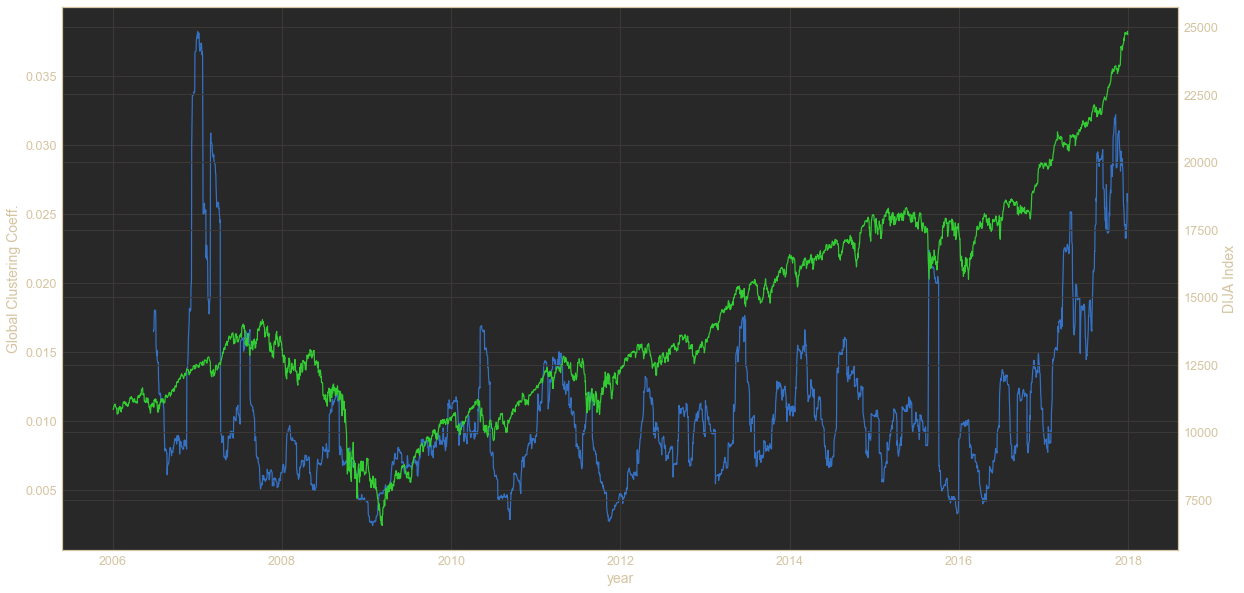

In [173]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.pct_change().rolling(30).std())
ax.set_xlabel("year", fontsize=14)
ax.set_ylabel("Global Clustering Coeff.", fontsize=14)

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)

In [43]:
dft.pct_change().rolling(30).std()[dft.pct_change().rolling(30).std()['90d_global_clustering_coefficient'] == dft.pct_change().rolling(30).std().max()[0]]

,90d_global_clustering_coefficient
Date,
2007-01-03,0.0382


In [178]:
dft['crisis_coeff'] = dft[['90d_global_clustering_coefficient']].pct_change().rolling(30).std()

In [207]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

data = dft[['crisis_coeff']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled).dropna()

#train OneClassSVM
outliers_fraction = 0.01
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
anomalies = pd.Series(model.predict(data), index=dft.index)

In [208]:
dft['anomaly'] = anomalies

In [210]:
dft[dft['anomaly'] == -1]

,90d_global_clustering_coefficient,crisis_coeff,anomaly
Date,,,
2006-12-27,0.366834,0.036892,-1
2006-12-28,0.379863,0.037599,-1
2006-12-29,0.373657,0.037662,-1
2007-01-03,0.359096,0.038200,-1
2007-01-04,0.377361,0.037698,-1
2007-01-05,0.367595,0.037968,-1
2007-01-08,0.377162,0.038087,-1
2007-01-09,0.376834,0.038001,-1
2007-01-10,0.377835,0.037127,-1


No handles with labels found to put in legend.


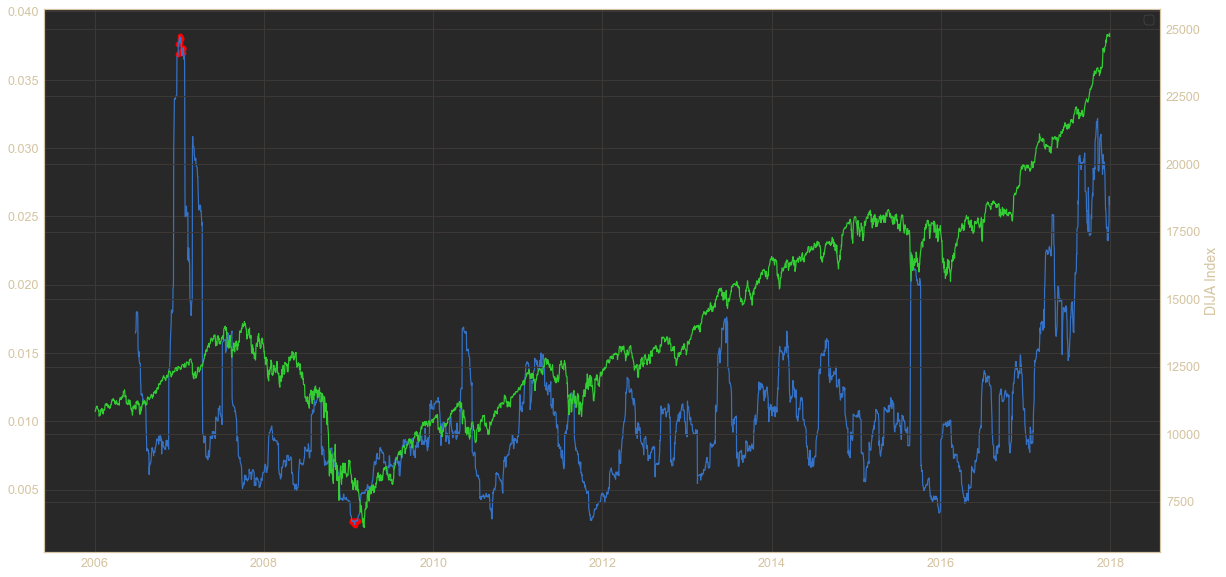

In [221]:
a = dft.loc[dft['anomaly'] == -1, ['crisis_coeff']]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['crisis_coeff'], label='Normal')
ax.scatter(a.index, a['crisis_coeff'], color='red', label='Anomaly')

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
plt.legend()

In [219]:
a.index

DatetimeIndex(['2006-12-27', '2006-12-28', '2006-12-29', '2007-01-03',
               '2007-01-04', '2007-01-05', '2007-01-08', '2007-01-09',
               '2007-01-10', '2007-01-11', '2007-01-16', '2007-01-17',
               '2007-01-18', '2007-01-19', '2009-01-14', '2009-01-15',
               '2009-01-16', '2009-01-20', '2009-01-23', '2009-01-26',
               '2009-01-27', '2009-01-28', '2009-01-29', '2009-01-30',
               '2009-02-02', '2009-02-05', '2009-02-06', '2009-02-09'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [26]:
import ipyhc as hc

dija_index_series = hc.build.series(df_dija_index[['Close']])
df_clustering_series = hc.build.series(dft[['90d_global_clustering_coefficient']].pct_change().rolling(30).std())

In [27]:
df_clustering_series[0]['yAxis'] = 1

In [28]:
options = {
    'credits': {'enabled': True,
                'text': 'Source: XXX Flow Strategy & Solutions.',
                'href': 'http://www.example.com'},
    'exporting': {'enabled': True},
    'chart': {'zoomType': 'xy'},
    'plotOptions': {'series': {'compare': 'percent'}},
    'legend': {'enabled': True,
               'layout': 'horizontal',
               'align': 'center',
               'maxHeight': 100},
    'tooltip': {'enabled': True,
                'valueDecimals': 5,
                'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.change}%)<br/>',
                'positioner': "function(labelWidth, labelHeight, point) {\n    var roundUp100 = function(d) { return 100*Math.floor(d/100); },\n        labelWidth = roundUp100(labelWidth),\n        chart = window.charts['__uuid__'];\n\n    var tooltipX, tooltipY;\n        var testX = (point.plotX + labelWidth * 0.7 > chart.plotWidth / 2) && (point.plotX - labelWidth * 0.7 < chart.plotWidth / 2);\n        var testY = point.plotY < labelHeight * 0.7;\n\n    if (testX && testY) {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop + chart.plotHeight - labelHeight;\n    } else {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop;\n    }\n\n    return {\n        x: tooltipX,\n        y: tooltipY\n    };\n}\n\n"},
    'title': {'text': 'Time series plotted with HighStock'},
    'subtitle': {'text': 'Transparent access to the underlying js lib'},
    'yAxis': [
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
        },
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
            'title': {
                'text': '% change'
            }
        }
    ],
    'xAxis': {
        'gridLineWidth': 1.0, 
        'gridLineDashStyle': 'Dot'},
}

chart = hc.Chart(height=700, width=1200, stock = True, options = options, data = dija_index_series + df_clustering_series)
chart

Chart(height='700px', stock=True, width='1200px')